# OpenAIRE Graph University Overview

This notebook fetches summary statistics per university using the [OpenAIRE Graph API](https://graph.openaire.eu/docs/apis/graph-api/). For every listed university we compare three perspectives:

- **A. Publications affiliated to the university** – filter on the OpenAIRE OpenORG identifier.
- **B. Publications collected by the main (CRIS) data source** – filter on the CRS/data source identifier.
- **C. Publications collected by the secondary repository** – filter on the repository identifier when available.

For each perspective we retrieve counts for funding/projects, data sources, and research products split into publications, datasets, software, and other research outputs. The notebook separates the data collection steps so that each can be re-run independently when debugging or iterating.


In [37]:
# install required packages (if not already installed)

!pip install pandas matplotlib openpyxl python-dotenv requests tqdm pyarrow


11463.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds


## 1. Imports and reused constants


In [38]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import os
import csv
import time
from copy import deepcopy
from io import StringIO
from pathlib import Path
from datetime import datetime
from typing import Any, Dict, Optional, Union

import matplotlib.pyplot as plt
import pandas as pd
import requests
from tqdm.auto import tqdm
from dotenv import load_dotenv

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda value: f"{value:,.0f}")

load_dotenv()

CLIENT_ID = os.getenv("CLIENT_ID")
CLIENT_SECRET = os.getenv("CLIENT_SECRET")

if not CLIENT_ID or not CLIENT_SECRET:
    raise RuntimeError(
        "Missing OpenAIRE credentials. Set CLIENT_ID and CLIENT_SECRET in the environment."
    )

BASE_URL = "https://api.openaire.eu/graph"
TOKEN_URL = "https://aai.openaire.eu/oidc/token"
API_USER_AGENT = "OpenAIRE-tools overview-stats notebook"
API_PAUSE_SECONDS = 0.1  # throttle requests a bit to stay within rate limits
TOKEN_REFRESH_BUFFER = 60  # refresh the token one minute before expiration

DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)
IMG_DIR = Path("img")
IMG_DIR.mkdir(exist_ok=True)

PRODUCT_TYPE_LABELS = {
    "publication": "Publications",
    "dataset": "Research data",
    "software": "Research software",
    "other": "Other research products",
}

METRIC_ORDER = [
    "Funding / Projects",
    "Data sources",
    *PRODUCT_TYPE_LABELS.values(),
]

COMPARISON_LONG_PATH = DATA_DIR / "comparison_long.csv"
COMPARISON_PIVOT_PATH = DATA_DIR / "comparison_pivot.csv"

_access_token: Optional[str] = None
_access_token_expiry: float = 0.0

print("Setup complete.")


Setup complete.


## 2. Parse the university reference table
The raw table below mirrors the values supplied in the request. We reshape it into a structured list so that the rest of the notebook can iterate over the entries.


In [ ]:
# 2. Load the NL organizations reference table
# Download the latest NL organizations baseline from the Google Sheets URL

# URL of the published Google Sheets NL organizations baseline
nl_orgs_baseline_url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vTDQiWDIaI1SZkPTMNCovicBhA-nQND1drXoUKvrG1O_Ga3hLDRvmQZao_TvNgmNQ/pub?output=xlsx"
# Local path to store the downloaded baseline
NL_ORGS_BASELINE_PATH = DATA_DIR / "nl_orgs_baseline.xlsx"
# Name of the sheet containing the NL organizations data
NL_ORGS_SHEET_NAME = "nl-orgs"

# Function to download the NL organizations baseline
def download_nl_orgs_baseline(url: str, dest: Path) -> Path:
    """Download the latest NL organizations baseline and store it locally."""
    # Ensure the destination directory exists
    dest.parent.mkdir(parents=True, exist_ok=True)
    if dest.exists():
        print(f"Using existing baseline file: {dest}")
        return dest
        
    print(f"Downloading baseline file from {url}")
    # Download the file
    response = requests.get(url, timeout=120)
    response.raise_for_status()
    dest.write_bytes(response.content)
    print(f"Saved baseline file to: {dest}")
    return dest

# Download the NL organizations baseline
download_nl_orgs_baseline(nl_orgs_baseline_url, NL_ORGS_BASELINE_PATH)

# Set the table path to the downloaded baseline
TABLE_PATH = NL_ORGS_BASELINE_PATH

# Load and parse the NL organizations reference table
def load_university_table(path: Union[str, Path], sheet_name: str) -> pd.DataFrame:
    """Load the NL organizations reference table and normalise empty values to blanks."""
    table_path = Path(path)
    if not table_path.exists():
        raise FileNotFoundError(f"Reference table not found: {table_path}")
    excel_suffixes = {".xlsx", ".xls"}
    if table_path.suffix.lower() in excel_suffixes:
        # Load the Excel file
        df = pd.read_excel(table_path, sheet_name=sheet_name, dtype=str, keep_default_na=False)
    else:
        # Load as a TSV/CSV file
        df = pd.read_csv(table_path, sep="	", dtype=str, keep_default_na=False)
    return df.fillna("")

# Helper function to pick the first non-empty value from a list of columns
def _pick(row: pd.Series, *columns: str) -> str:
    for column in columns:
        if column not in row:
            continue
        value = row[column]
        if isinstance(value, str):
            value = value.strip()
        if value:
            return value
    return ""

# Normalize ROR link
def normalise_ror_link(value: str) -> str:
    # Normalize ROR identifier to a full URL
    value = (value or "").strip()
    # If the value is empty after stripping, return an empty string
    if not value:
        return ""
    # If the value already starts with "http", return it as is
    if value.startswith("http"):
        return value
    # If the value starts with "ror.org", prepend "https://"
    if value.startswith("ror.org"):
        return f"https://{value}"
    # Otherwise, assume it's a ROR ID and construct the full URL
    value = value.strip().strip("/")
    # If the value is empty after stripping, return an empty string
    if not value:
        return ""
    # Return the full ROR URL
    return f"https://ror.org/{value}"

# Extract ROR ID from a value
def extract_ror_id(value: str) -> str:
    value = (value or "").strip()
    if not value:
        return ""
    if value.startswith("http"):
        value = value.rstrip("/").split("/")[-1]
    return value

# Parse university rows from the DataFrame
def parse_university_rows(df: pd.DataFrame) -> list[dict[str, Optional[str]]]:
    # Parse university rows from the DataFrame and extract relevant fields
    parsed: list[dict[str, Optional[str]]] = []
    # Iterate over each row in the DataFrame
    for _, row in df.iterrows():
        # Determine the university name using multiple possible columns
        name = _pick(row, "full_name_in_English", "University", "organization_name")
        # Skip rows without a valid name
        if not name:
            continue
        
        # Extract and normalize ROR information
        ror_id = extract_ror_id(_pick(row, "ROR"))
        # Normalize ROR link
        ror_link = normalise_ror_link(_pick(row, "ROR_LINK") or ror_id)
        # If ROR link is available but ROR ID is not, extract ROR ID from the link
        if ror_link and not ror_id:
            # Extract ROR ID from the normalized ROR link
            ror_id = extract_ror_id(ror_link)

        # Construct the university entry
        entry = {
            "name": name,
            "acronym_EN": _pick(row, "acronym_EN") or None,
            "acronym_AGG": _pick(row, "acronym_AGG") or None,
            "grouping": _pick(row, "main_grouping") or None,
            "ROR": ror_id or None,
            "ROR_LINK": ror_link or None,
            "OpenAIRE_ORG_ID": _pick(row, "OpenAIRE_ORG_ID", "OpenAIRE OpenORG ID", "OpenAIRE OpenORG ID LINK", "openorg_id") or None,
            "main_datasource_id": _pick(row, "OpenAIRE Data Source ID (Main/CRIS)", "OpenAIRE Data Source ID (Main/CRIS) LINK", "main_datasource_id") or None,
            "secondary_datasource_id": _pick(row, "OpenAIRE Data Source (Secondary/Repository)", "OpenAIRE Data Source (Secondary/Repository) LINK", "secondary_datasource_id") or None,
        }
        # Special handling for OpenDOAR IDs
        if entry["main_datasource_id"] and entry["main_datasource_id"].startswith("opendoar"):
            if not entry["secondary_datasource_id"]:
                entry["secondary_datasource_id"] = entry["main_datasource_id"]
                entry["main_datasource_id"] = None
        # Append the parsed entry to the list
        parsed.append(entry)

    # Return the parsed university entries
    return parsed

# Load the NL organizations reference table and parse universities
nl_orgs_df = load_university_table(TABLE_PATH, NL_ORGS_SHEET_NAME)
# Parse universities from the loaded DataFrame
universities = parse_university_rows(nl_orgs_df)
# Display the number of parsed universities
print(f"Parsed {len(universities)} universities from the reference table (loaded from {TABLE_PATH}).")
# Convert the list of universities to a DataFrame for display
universities_df = pd.DataFrame(universities)
# Display the DataFrame of universities
universities_df


Using existing baseline file: data/nl_orgs_baseline.xlsx
Parsed 93 universities from the reference table (loaded from data/nl_orgs_baseline.xlsx).


,name,acronym_EN,acronym_AGG,grouping,ROR,ROR_LINK,OpenAIRE_ORG_ID,main_datasource_id,secondary_datasource_id
0,Data Archiving Networked Services (DANS),DANS,DANS,KNAW,008pnp284,https://ror.org/008pnp284,None,None,None
1,Hubrecht Institute for Developmental Biology a...,HUBRECHT,HUBRECHT,KNAW,023qc4a07,https://ror.org/023qc4a07,None,None,None
2,International Institute of Social History (IISH),IISH,IISH,KNAW,05dq4pp56,https://ror.org/05dq4pp56,None,None,None
3,Royal Netherlands Institute of Southeast Asian...,KITLV,KITLV,KNAW,01bdv4312,https://ror.org/01bdv4312,None,None,None
4,Royal Netherlands Academy of Arts and Sciences,KNAW,KNAW,KNAW,043c0p156,https://ror.org/043c0p156,None,None,None
5,Netherlands Institute for Neuroscience,NIN,NIN,KNAW,05csn2x06,https://ror.org/05csn2x06,None,None,None
6,Netherlands Institute of Ecology (NIOO),NIOO,NIOO,KNAW,01g25jp36,https://ror.org/01g25jp36,None,None,None
7,Westerdijk Fungal Biodiversity Institute,WESTERDIJK,WESTERDIJK,KNAW,030a5r161,https://ror.org/030a5r161,None,None,None
8,Amsterdam UMC,AUMC,AUMC,NFU,05grdyy37,https://ror.org/05grdyy37,None,None,None
9,ErasmusMC,ErasmusMC,EUR/ErasmusMC,NFU,018906e22,https://ror.org/018906e22,None,None,None


## 3. Helper functions for the Graph API
These functions wrap the REST requests and centralise filter construction per scenario. Each call prints nothing by default so we can reuse them freely in later cells.


In [14]:
# Define the different scenarios for metrics collection.
# Each scenario includes a key, label, ID field, and description.
# For each scenario, we will build appropriate filters to query the OpenAIRE Graph API.
# For example, we can collect metrics based on organization affiliation,
# main data source, or secondary repository.
# Each scenario will have its own set of filters.

SCENARIO_DEFS = [
    {
        "key": "organization",
        "label": "A. OpenORG affiliation",
        "id_field": "OpenAIRE_ORG_ID",
        "description": "Publications affiliated to the university (OpenAIRE OpenORG ID)",
    },
    {
        "key": "main_datasource",
        "label": "B. Main/CRIS data source",
        "id_field": "main_datasource_id",
        "description": "Publications collected from the main CRIS data source",
    },
    {
        "key": "secondary_datasource",
        "label": "C. Secondary repository",
        "id_field": "secondary_datasource_id",
        "description": "Publications collected from the secondary / repository data source",
    },
]

# Define filter builders for each scenario.
# Each builder function takes an entity ID and returns a dictionary of filters
# for projects, data sources, and research products.
#   - The filters are used to query the OpenAIRE Graph API for relevant metrics.

FILTER_BUILDERS = {
    "organization": lambda entity_id: {
        "projects": {"relOrganizationId": entity_id},
        "dataSources": {"relOrganizationId": entity_id},
        "researchProducts": {"relOrganizationId": entity_id},
    },
    "main_datasource": lambda entity_id: {
        "projects": {"relCollectedFromDatasourceId": entity_id},
        "dataSources": {"id": entity_id},
        "researchProducts": {"relCollectedFromDatasourceId": entity_id},
    },
    "secondary_datasource": lambda entity_id: {
        "projects": {"relCollectedFromDatasourceId": entity_id},
        "dataSources": {"id": entity_id},
        "researchProducts": {"relCollectedFromDatasourceId": entity_id},
    },
}

# Define an empty metrics dictionary for collecting results.
EMPTY_METRICS = {metric: None for metric in METRIC_ORDER}

# Obtain a cached OpenAIRE access token, refreshing it when needed.
def obtain_access_token() -> str:
    """Return a cached OpenAIRE access token, refreshing it when needed."""
    global _access_token, _access_token_expiry
    now = time.time()
    if _access_token and now < _access_token_expiry:
        return _access_token

    response = requests.post(
        TOKEN_URL,
        data={"grant_type": "client_credentials"},
        auth=(CLIENT_ID, CLIENT_SECRET),
        headers={"User-Agent": API_USER_AGENT},
        timeout=60,
    )
    response.raise_for_status()
    payload = response.json()
    token = payload.get("access_token")
    if not token:
        raise RuntimeError("OpenAIRE token response did not include an access_token.")
    expires_in = int(payload.get("expires_in", 3600))
    _access_token = token
    _access_token_expiry = now + max(expires_in - TOKEN_REFRESH_BUFFER, 0)
    return _access_token

# Invoke the OpenAIRE Graph API and return the decoded JSON payload.
def call_graph_api(path: str, params: Optional[Dict[str, Any]] = None) -> Dict[str, Any]:
    """Invoke the OpenAIRE Graph API and return the decoded JSON payload."""
    url = f"{BASE_URL}{path}"
    effective_params = dict(params or {})
    effective_params.setdefault("page", 1)
    effective_params.setdefault("pageSize", 1)

    headers = {
        "User-Agent": API_USER_AGENT,
        "Authorization": f"Bearer {obtain_access_token()}",
    }

    response = requests.get(
        url,
        params=effective_params,
        headers=headers,
        timeout=60,
    )
    response.raise_for_status()
    time.sleep(API_PAUSE_SECONDS)
    return response.json()

# Retrieve the total number of matching records for the supplied endpoint.
def fetch_num_found(path: str, params: Dict[str, Any]) -> Optional[int]:
    """Return the total number of matching records for the supplied endpoint."""
    payload = call_graph_api(path, params)
    header = payload.get("header", {})
    num_found = header.get("numFound")
    return int(num_found) if num_found is not None else None

# Build filters for the given scenario and entity ID.
def build_filters(scenario_key: str, entity_id: str) -> Dict[str, Dict[str, Any]]:
    builder = FILTER_BUILDERS[scenario_key]
    return {name: dict(filters) for name, filters in builder(entity_id).items()}


# Collect metrics for a given scenario and entity ID.
def collect_metrics(scenario_key: str, entity_id: Optional[str]) -> Dict[str, Optional[int]]:
    if not entity_id:
        return deepcopy(EMPTY_METRICS)

    filters = build_filters(scenario_key, entity_id)
    results: Dict[str, Optional[int]] = {}

    results["Funding / Projects"] = fetch_num_found("/v1/projects", filters["projects"])
    results["Data sources"] = fetch_num_found("/v1/dataSources", filters["dataSources"])

    for rp_type, label in PRODUCT_TYPE_LABELS.items():
        rp_params = dict(filters["researchProducts"], type=rp_type)
        results[label] = fetch_num_found("/v2/researchProducts", rp_params)

    return results


In [15]:
from functools import lru_cache

# Cache OpenAIRE ID lookups to avoid redundant API calls

@lru_cache(maxsize=None)
def _fetch_openorg_id(ror_url: str) -> Optional[str]:
    # Query the OpenAIRE Graph API for the organization with the given ROR URL
    try:
        payload = call_graph_api("/v1/organizations", {"pid": ror_url})
    except requests.RequestException as exc:
        print(f"Failed to fetch OpenAIRE ID for {ror_url}: {exc}")
        return None

    # Extract the OpenAIRE organization ID from the response
    results = payload.get("results") or []
    for item in results:
        openorg_id = item.get("id")
        if openorg_id:
            return openorg_id
    return None

# Look up the OpenAIRE organization identifier using a ROR ID or URL.

def fetch_openorg_id_for_ror(ror_value: Optional[str]) -> Optional[str]:
    """Look up the OpenAIRE organization identifier using a ROR ID or URL."""
    if not ror_value:
        return None
    # Normalize the ROR value to a URL
    ror_url = normalise_ror_link(ror_value)
    if not ror_url:
        return None
    # Look up the OpenAIRE organization ID using the normalized ROR URL
    return _fetch_openorg_id(ror_url)


## 4. Test for one university

Run a quick test for the first university in the list to fetch the 
  OpenORG affiliation,
  and the Number of: 
  Funding / Projects,
  Data sources, 
  Products: Total,
  Products: Publications, 
  Products: Research data, 
  Products: Research software,
  Products: Other research products

In [16]:
# Example: collect and display metrics for the first university in the list
test_university = universities[0]
print(f"Testing metrics for: {test_university['name']}")

# Determine the OpenAIRE organization identifier
identifier = test_university.get("OpenAIRE_ORG_ID")
if not identifier:
    # Try to resolve it via the ROR ID/link
    resolved = fetch_openorg_id_for_ror(test_university.get("ROR_LINK") or test_university.get("ROR"))
    identifier = resolved

# Collect and display metrics    
print(f"\nOpenAIRE ID: {identifier}")
print("\nMetrics:")
# Collect metrics for the organization
metrics = collect_metrics("organization", identifier)

# Calculate total research products
research_products_total = sum(
    metrics.get(product_type, 0) or 0 
    for product_type in ["Publications", "Research data", "Research software", "Other research products"]
)
print("Total Research Products:", research_products_total)
print("\nBreakdown by type:")

# Display the collected metrics
for metric, count in metrics.items():
    print(f"{metric}: {count}")

Testing metrics for: Data Archiving Networked Services (DANS)

OpenAIRE ID: openorgs____::a8767e80afb51d63802fdf1ddabeacb0

Metrics:
Total Research Products: 10231

Breakdown by type:
Funding / Projects: 0
Data sources: 16
Publications: 438
Research data: 9561
Research software: 99
Other research products: 133


## 5. Collect metrics for all universities
Loop through every organisation, ensure an OpenAIRE identifier is available, and add this information to new columns. and write to file nl_orgs_openaire.xlsx

In [18]:
# 3. Enrich the NL organizations table with OpenAIRE IDs and metrics

# Copy the university table so we can enrich it without mutating the original
enriched_df = universities_df.copy()

# Ensure all metric columns exist in the DataFrame
metric_columns = [
    "Data sources",
    "Total Research Products",
    "Publications",
    "Research data",
    "Research software",
    "Other research products",
]
for column in metric_columns:
    if column not in enriched_df.columns:
        enriched_df[column] = pd.NA

# Define output paths
output_path = DATA_DIR / "nl_orgs_openaire.xlsx"
checkpoint_path = DATA_DIR / "nl_orgs_openaire.tmp.xlsx"

# Define parameters for enrichment process
save_every = 5 # save every N rows
max_workers = 6 # number of concurrent workers

# Function to enrich a single row with OpenAIRE ID and metrics
def enrich_row(idx: int) -> tuple[int, dict[str, Any]]:
    # Enrich a single row with OpenAIRE ID and metrics
    row = enriched_df.loc[idx]
    # Get the OpenAIRE ID
    identifier = row.get("OpenAIRE_ORG_ID")
    # define flag to indicate if ID was added
    added_id = False
    # Try to resolve OpenAIRE ID via ROR if not already present
    if not identifier:
        identifier = fetch_openorg_id_for_ror(row.get("ROR_LINK") or row.get("ROR"))
        if identifier:
            added_id = True
    
    # Collect metrics for the organization
    metrics = collect_metrics("organization", identifier)
    result = {
        "OpenAIRE_ORG_ID": identifier,
    }

    # Populate metric columns
    if identifier and metrics:
        # Calculate total research products
        total_products = sum((metrics.get(label) or 0) for label in metric_columns[2:])
        
        for column in metric_columns:
            if column == "Total Research Products":
                result[column] = total_products
            else:
                result[column] = metrics.get(column)
    else:
        for column in metric_columns:
            result[column] = pd.NA

    result["added_id"] = added_id
    return idx, result

# Enrich the DataFrame with OpenAIRE IDs and metrics using multithreading
from concurrent.futures import ThreadPoolExecutor, as_completed

# define progress bar
progress = tqdm(enriched_df.index, desc="Enriching OpenAIRE IDs & metrics", unit="org")
enriched_count = 0
pending = set()

# Use ThreadPoolExecutor to process rows concurrently
with ThreadPoolExecutor(max_workers=max_workers) as executor:
    futures = {executor.submit(enrich_row, idx): idx for idx in enriched_df.index}
    for processed, future in enumerate(as_completed(futures), start=1):
        idx, result = future.result()
        enriched_df.at[idx, "OpenAIRE_ORG_ID"] = result["OpenAIRE_ORG_ID"]
        for column in metric_columns:
            enriched_df.at[idx, column] = result[column]
        if result.get("added_id"):
            enriched_count += 1
        progress.update(1)
        if processed % save_every == 0:
            enriched_df.to_excel(checkpoint_path, index=False)
            progress.set_postfix(saved_rows=processed)

# Close the progress bar
progress.close()

# Save the final enriched DataFrame to Excel
enriched_df.to_excel(output_path, index=False)

# Print summary of enrichment process
print(f"Added OpenAIRE IDs for {enriched_count} organizations")
print(f"Saved enriched data to {output_path}")
if checkpoint_path.exists():
    print(f"Checkpoint saved to {checkpoint_path}")

# Display the first few rows of the enriched DataFrame
enriched_df.head()

# Print summary of organizations still missing OpenAIRE IDs
missing_ids = enriched_df[enriched_df["OpenAIRE_ORG_ID"].isna() | (enriched_df["OpenAIRE_ORG_ID"] == "")]
if not missing_ids.empty:
    print("Organizations still missing OpenAIRE IDs:")
    for name in missing_ids['name']:
        print(f"- {name}")


Enriching OpenAIRE IDs & metrics:   0%|          | 0/93 [00:00<?, ?org/s]

Enriching OpenAIRE IDs & metrics: 100%|██████████| 93/93 [00:37<00:00,  2.51org/s, saved_rows=90]

Added OpenAIRE IDs for 85 organizations
Saved enriched data to data/nl_orgs_openaire.xlsx
Checkpoint saved to data/nl_orgs_openaire.tmp.xlsx
Organizations still missing OpenAIRE IDs:
- UMCG
- Wetenschappelijk Onderzoek- en Documentatiecentrum
- University of Humanistic Studies
- VH (HBO Kennisbank)
- Theological University
- Jan Ingenhouszinstituut
- Nationaal Archief of the Netherlands
- Total


## 6. Visualise total research products per organisation
Convert the enriched metrics to numeric form and plot the total research products per organisation (sorted descending).

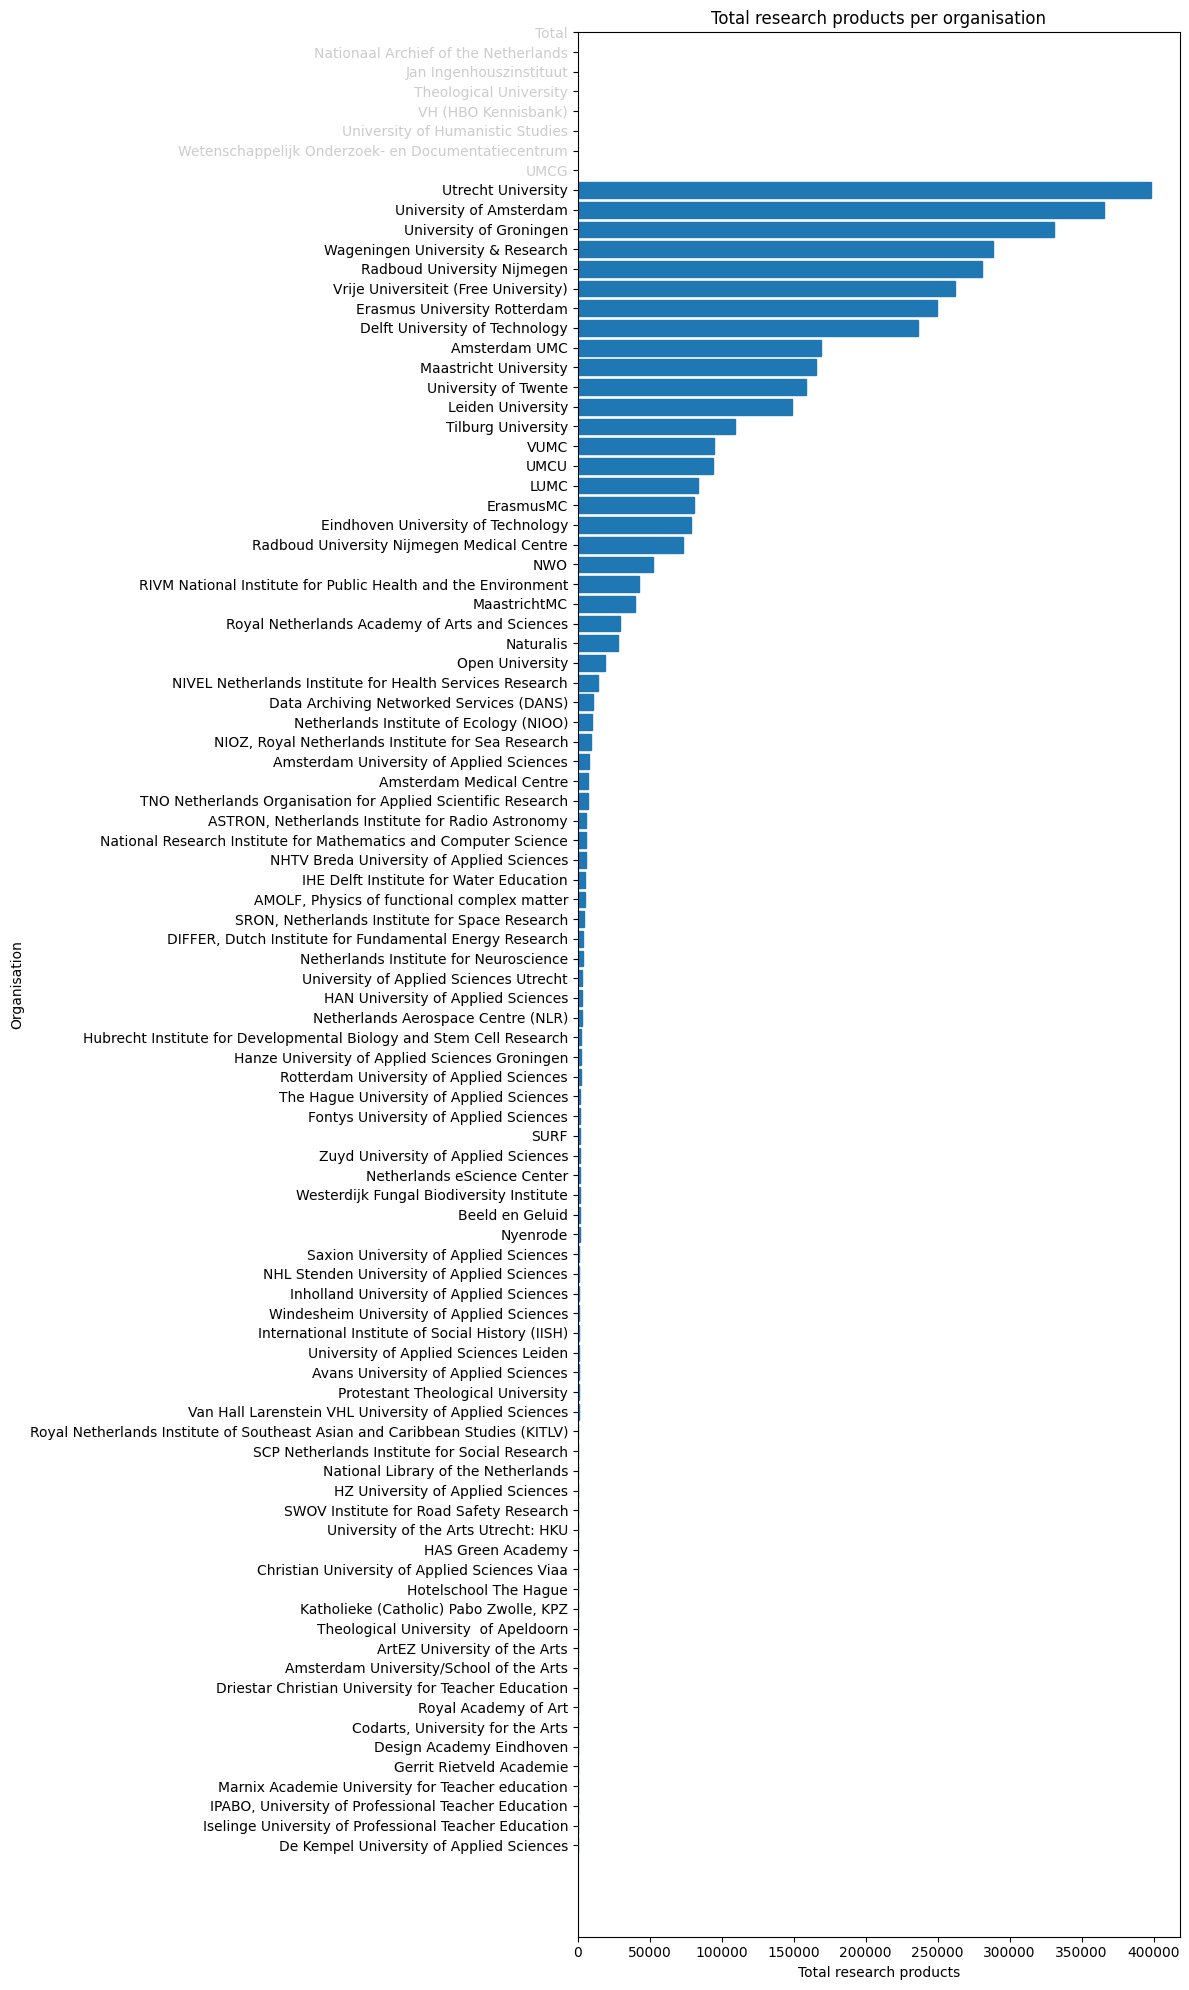

In [23]:
numeric_columns = [
    "Total Research Products",
    "Publications",
    "Research data",
    "Research software",
    "Other research products",
]

for column in numeric_columns:
    enriched_df[column] = pd.to_numeric(enriched_df[column], errors="coerce")

plot_df = enriched_df.sort_values("Total Research Products", ascending=True)

fig, ax = plt.subplots(figsize=(12, 20))
has_missing_id = plot_df["OpenAIRE_ORG_ID"].isna()
bars = ax.barh(range(len(plot_df)), plot_df["Total Research Products"])
for idx, missing in enumerate(has_missing_id):
    bars[idx].set_color("#cccccc" if missing else "#1f77b4")

ax.set_yticks(range(len(plot_df)))
ax.set_yticklabels(plot_df["name"])
for idx, label in enumerate(ax.get_yticklabels()):
    label.set_color("#cccccc" if has_missing_id.iloc[idx] else "black")

ax.set_xlabel("Total research products")
ax.set_ylabel("Organisation")
ax.set_title("Total research products per organisation")
fig.tight_layout()
org_chart_path = IMG_DIR / "org_total_products.png"
fig.savefig(org_chart_path, dpi=200, bbox_inches="tight")
print(f"Saved organisation totals chart to {org_chart_path}")
plt.show()


## 7. Fetch data source metadata
Retrieve every OpenAIRE data source linked to the enriched organisations and cache the registry details.

In [ ]:
# 4. Fetch and store OpenAIRE data source metadata for NL organizations

# Define the columns for the data source metadata
datasource_columns = [
    "OpenAIRE_ORG_ID",
    "OpenAIRE_DataSource_ID",
    "Name",
    "Type",
    "OAI-endpoint",
    "supports_NL-DIDL",
    "support_OAI-DC",
    "support_OAI-openaire",
    "supports_RIOXX",
    "support_OpenAIRE-CERIF",
    "openaireCompatibility",
    "Last_Indexed_Date",
    "dateOfValidation",
]

# Parse a single data source record from the API response
def _parse_datasource_record(org_id: Optional[str], item: Dict[str, Any]) -> dict[str, Any]:
    name = item.get("officialName") or item.get("englishName")
    ds_type = (item.get("type") or {}).get("value")
    record = {
        "OpenAIRE_ORG_ID": org_id,
        "OpenAIRE_DataSource_ID": item.get("id"),
        "Name": name,
        "Type": ds_type,
        "OAI-endpoint": item.get("websiteUrl"),
        "supports_NL-DIDL": None,
        "support_OAI-DC": None,
        "support_OAI-openaire": None,
        "supports_RIOXX": None,
        "support_OpenAIRE-CERIF": None,
        "openaireCompatibility": item.get("openaireCompatibility"),
        "Last_Indexed_Date": item.get("lastIndexedDate") or item.get("lastIndexDate"),
        "dateOfValidation": item.get("dateOfValidation"),
    }
    return record

# Fetch all data sources for a given organization
def fetch_datasources_for_org(org_entry: dict[str, Any]) -> list[dict[str, Any]]:
    org_id = org_entry.get("OpenAIRE_ORG_ID")
    if not org_id:
        return []

    records: list[dict[str, Any]] = []
    page = 1
    page_size = 100
    while True:
        payload = call_graph_api(
            "/v1/dataSources",
            {
                "relOrganizationId": org_id,
                "page": page,
                "pageSize": page_size,
            },
        )
        results = payload.get("results") or []
        for item in results:
            records.append(_parse_datasource_record(org_id, item))

        header = payload.get("header") or {}
        num_found = header.get("numFound", 0)
        if page * page_size >= num_found or not results:
            break
        page += 1

    return records

# Fetch data sources for all organizations and compile into a DataFrame
datasource_records: list[dict[str, Any]] = []
org_entries = enriched_df.to_dict("records")

# Use ThreadPoolExecutor to fetch data sources concurrently
with ThreadPoolExecutor(max_workers=6) as executor:
    futures = {executor.submit(fetch_datasources_for_org, entry): entry for entry in org_entries}
    for future in tqdm(
        as_completed(futures),
        total=len(org_entries),
        desc="Fetching data sources",
        unit="org",
    ):
        datasource_records.extend(future.result())

# Compile the data source records into a DataFrame
datasources_df = pd.DataFrame(datasource_records, columns=datasource_columns)

# Save the data sources DataFrame to Excel
datasources_path = DATA_DIR / "nl_orgs_openaire_datasources.xlsx"
datasources_df.to_excel(datasources_path, index=False)
print(f"Saved {len(datasources_df)} data source rows to {datasources_path}")
datasources_df.head()


Fetching data sources: 100%|██████████| 93/93 [00:07<00:00, 12.09org/s]


Saved 170 data source rows to data/nl_orgs_openaire_datasources.xlsx


,OpenAIRE_ORG_ID,OpenAIRE_DataSource_ID,Name,Type,OAI-endpoint,supports_NL-DIDL,support_OAI-DC,support_OAI-openaire,supports_RIOXX,support_OpenAIRE-CERIF,openaireCompatibility,Last_Indexed_Date,dateOfValidation
0,openorgs____::cb77737b5a390319030e6abdb12aa6ad,opendoar____::97275a23ca44226c9964043c8462be96,KNAW Repository,Institutional Repository,http://pure.knaw.nl/portal/,None,None,None,None,None,collected from a compatible aggregator,None,None
1,openorgs____::cb77737b5a390319030e6abdb12aa6ad,re3data_____::c4493890b3fefddfe9408389ff121d43,DANS Data Station Physical and Technical Sciences,Data Repository,https://phys-techsciences.datastations.nl/,None,None,None,None,None,Not yet registered,None,None
2,openorgs____::cb77737b5a390319030e6abdb12aa6ad,re3data_____::10d900a394f89a7148e1ae18b7b66aa0,Huygens ING,Data Repository,https://www.huygens.knaw.nl/?lang=en,None,None,None,None,None,Not yet registered,None,None
3,openorgs____::cb77737b5a390319030e6abdb12aa6ad,re3data_____::84e123776089ce3c7a33db98d9cd15a8,EASY,Data Repository,https://easy.dans.knaw.nl/ui/home,None,None,None,None,None,Not yet registered,None,2015-01-14
4,openorgs____::a8369fe646a573e841439d2c24396b49,opendoar____::fe70c36866add1572a8e2b96bfede7bf,Repository ISS and Hivos,Institutional Repository,http://ir.iss.nl/,None,None,None,None,None,Not yet registered,None,None


## 8. Capture data source content volumes
Collect fresh numFound counts per data source (total and by product type) and store the snapshot with today's date.

In [35]:
if datasources_df.empty:
    print("No data sources available; skipping numFound snapshot.")
    datasource_metrics_df = pd.DataFrame(
        columns=[
            "OpenAIRE_DataSource_ID",
            "Name",
            "Total Research Products",
            *PRODUCT_TYPE_LABELS.values(),
            "date_retrieved",
        ]
    )
else:
    snapshot_date = datetime.utcnow().date().isoformat()

    def collect_datasource_counts(row: pd.Series) -> dict[str, Any]:
        datasource_id = getattr(row, "OpenAIRE_DataSource_ID", None)
        if not datasource_id:
            return {}
        metrics: dict[str, Any] = {
            "OpenAIRE_DataSource_ID": datasource_id,
            "Name": getattr(row, "Name", None),
            "date_retrieved": snapshot_date,
        }
        total_params = {"relCollectedFromDatasourceId": datasource_id}
        metrics["Total Research Products"] = fetch_num_found(
            "/v2/researchProducts", total_params
        )
        for rp_type, label in PRODUCT_TYPE_LABELS.items():
            rp_params = {"relCollectedFromDatasourceId": datasource_id, "type": rp_type}
            metrics[label] = fetch_num_found("/v2/researchProducts", rp_params)
        return metrics

    datasource_metrics: list[dict[str, Any]] = []
    with ThreadPoolExecutor(max_workers=6) as executor:
        futures = {
            executor.submit(collect_datasource_counts, row): row
            for row in datasources_df.itertuples(index=False)
        }
        for future in tqdm(
            as_completed(futures),
            total=len(futures),
            desc="Collecting numFound",
            unit="datasource",
        ):
            result = future.result()
            if result:
                datasource_metrics.append(result)

    datasource_metrics_df = pd.DataFrame(
        datasource_metrics,
        columns=[
            "OpenAIRE_DataSource_ID",
            "Name",
            "Total Research Products",
            *PRODUCT_TYPE_LABELS.values(),
            "date_retrieved",
        ],
    )

    snapshot_path = DATA_DIR / f"nl_orgs_openaire_datasources_numFound_{snapshot_date}.xlsx"
    datasource_metrics_df.to_excel(snapshot_path, index=False)
    print(
        f"Saved snapshot with {len(datasource_metrics_df)} data sources to {snapshot_path}"
    )

datasource_metrics_df.head()


/tmp/ipykernel_109587/2355310963.py:13: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  snapshot_date = datetime.utcnow().date().isoformat()

Saved snapshot with 170 data sources to data/nl_orgs_openaire_datasources_numFound_2025-11-07.xlsx


,OpenAIRE_DataSource_ID,Name,Total Research Products,Publications,Research data,Research software,Other research products,date_retrieved
0,re3data_____::10d900a394f89a7148e1ae18b7b66aa0,Huygens ING,0,0,0,0,0,2025-11-07
1,opendoar____::fe70c36866add1572a8e2b96bfede7bf,Repository ISS and Hivos,0,0,0,0,0,2025-11-07
2,re3data_____::c4493890b3fefddfe9408389ff121d43,DANS Data Station Physical and Technical Sciences,0,0,0,0,0,2025-11-07
3,opendoar____::97275a23ca44226c9964043c8462be96,KNAW Repository,0,0,0,0,0,2025-11-07
4,re3data_____::f134a3812781f724f5cd4292cdc7b31f,IISH Dataverse,0,0,0,0,0,2025-11-07


## 9. Append snapshot to parquet history
Keep a cumulative parquet log so repeated snapshots form a time series.

In [54]:
history_path = DATA_DIR / "nl_orgs_openaire_datasources_numFound_history.xlsx"
if datasource_metrics_df.empty:
    print("No snapshot data to append.")
else:
    if history_path.exists():
        historical_df = pd.read_excel(history_path)
        combined_df = pd.concat([historical_df, datasource_metrics_df], ignore_index=True)
    else:
        combined_df = datasource_metrics_df.copy()

    for column in [
        "Total Research Products",
        *PRODUCT_TYPE_LABELS.values(),
    ]:
        if column in combined_df.columns:
            combined_df[column] = pd.to_numeric(combined_df[column], errors="coerce")

    combined_df.to_excel(history_path, index=False)
    print(
        f"History now contains {len(combined_df)} rows at {history_path}"
    )


History now contains 170 rows at data/nl_orgs_openaire_datasources_numFound_history.xlsx


## 10. Visualise data source totals
Bar chart of the latest total research products per data source.

/tmp/ipykernel_109587/3829732858.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", max(len(unique_types), 1))


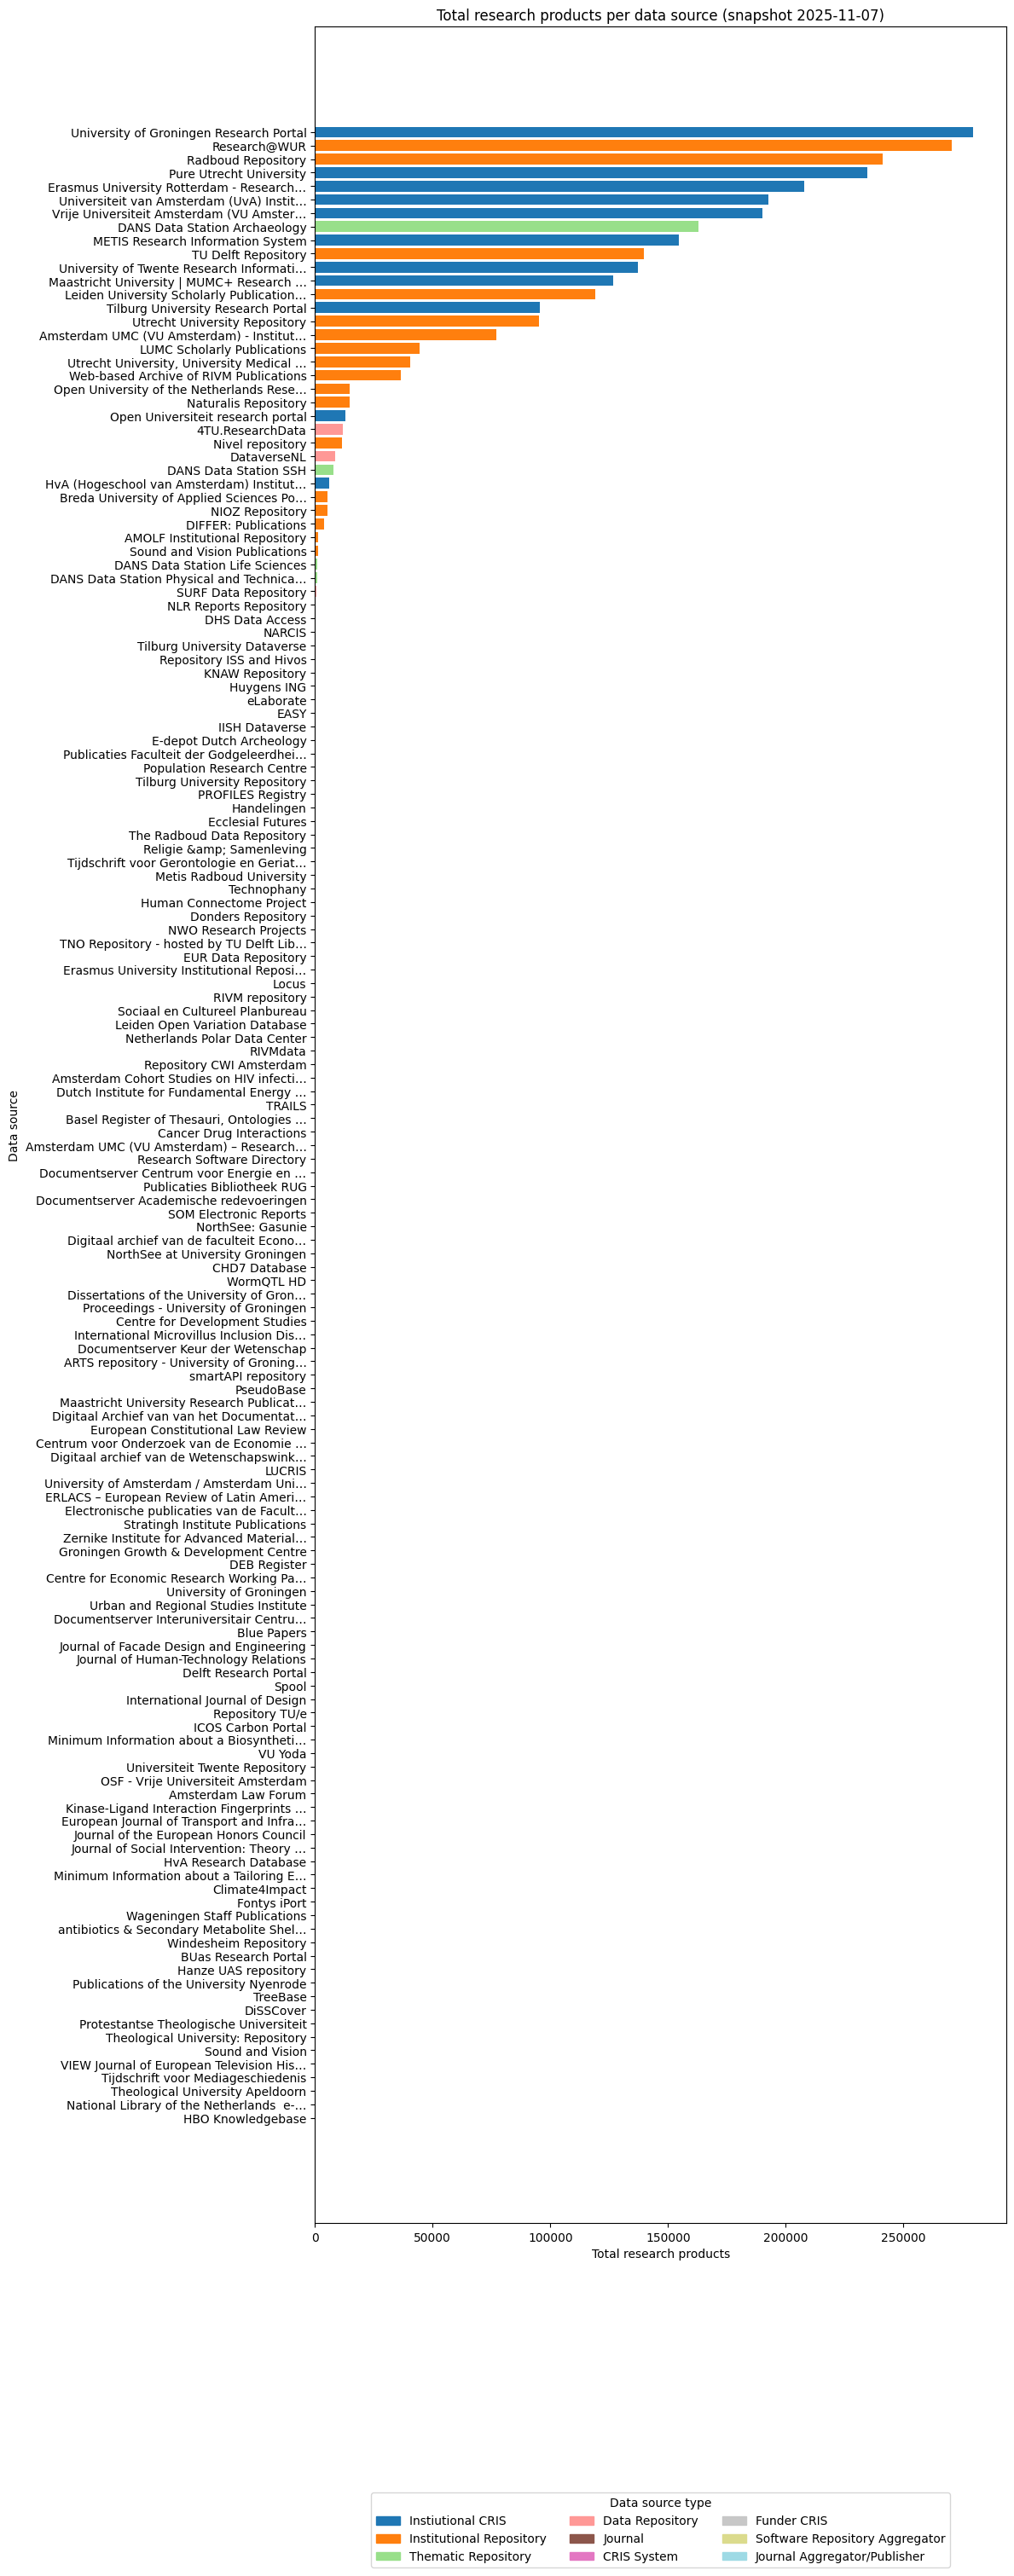

In [55]:
history_path = DATA_DIR / "nl_orgs_openaire_datasources_numFound_history.xlsx"
datasources_path = DATA_DIR / "nl_orgs_openaire_datasources.xlsx"
if not history_path.exists():
    print(f"History file {history_path} not found.")
else:
    history_df = pd.read_excel(history_path)
    numeric_columns = [
        "Total Research Products",
        *PRODUCT_TYPE_LABELS.values(),
    ]
    for column in numeric_columns:
        if column in history_df.columns:
            history_df[column] = pd.to_numeric(history_df[column], errors="coerce")

    history_df["date_retrieved"] = pd.to_datetime(history_df["date_retrieved"], errors="coerce")
    latest_date = history_df["date_retrieved"].max()
    latest_df = history_df[history_df["date_retrieved"] == latest_date].copy()

    if latest_df.empty:
        print("No rows for the latest snapshot date.")
    else:
        if "Type" not in latest_df.columns or latest_df["Type"].isna().all():
            if 'datasources_df' in globals():
                type_lookup = datasources_df[["OpenAIRE_DataSource_ID", "Type"]].copy()
            elif datasources_path.exists():
                type_lookup = pd.read_excel(datasources_path)[
                    ["OpenAIRE_DataSource_ID", "Type"]
                ].copy()
            else:
                type_lookup = pd.DataFrame(columns=["OpenAIRE_DataSource_ID", "Type"])

            latest_df = latest_df.merge(
                type_lookup,
                on="OpenAIRE_DataSource_ID",
                how="left",
                suffixes=(None, "_ds"),
            )
            if "Type_ds" in latest_df.columns:
                latest_df["Type"] = latest_df["Type"].fillna(latest_df["Type_ds"])
                latest_df = latest_df.drop(columns=["Type_ds"])

        latest_df = latest_df.sort_values("Total Research Products", ascending=False)
        max_label_length = 40
        display_names = (
            latest_df["Name"].fillna("Unknown")
            .astype(str)
            .apply(lambda text: text if len(text) <= max_label_length else text[: max_label_length - 1] + "…")
        )

        type_series = latest_df["Type"].fillna("Unknown")
        unique_types = type_series.unique()
        cmap = plt.cm.get_cmap("tab20", max(len(unique_types), 1))
        color_map = {t: cmap(i) for i, t in enumerate(unique_types)}
        colors = type_series.map(color_map)

        fig, ax = plt.subplots(figsize=(12, 30))
        ax.barh(display_names, latest_df["Total Research Products"], color=colors)
        ax.set_title(
            f"Total research products per data source (snapshot {latest_date.date()})"
        )
        ax.set_xlabel("Total research products")
        ax.set_ylabel("Data source")
        ax.invert_yaxis()

        handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[t]) for t in unique_types]
        ax.legend(
            handles,
            unique_types,
            title="Data source type",
            loc="upper center",
            bbox_to_anchor=(0.5, -0.12),
            ncol=3,
        )
        fig.tight_layout()
        chart_path = IMG_DIR / "datasource_totals_latest.png"
        fig.savefig(chart_path, dpi=200, bbox_inches="tight")
        print(f"Saved latest data source totals chart to {chart_path}")
        plt.show()


## 11. Compare latest vs previous snapshot
Show side-by-side totals for the latest two snapshots per data source.

In [56]:
history_path = DATA_DIR / "nl_orgs_openaire_datasources_numFound_history.xlsx"
datasources_path = DATA_DIR / "nl_orgs_openaire_datasources.xlsx"
if not history_path.exists():
    print(f"History file {history_path} not found.")
else:
    history_df = pd.read_excel(history_path)
    numeric_columns = [
        "Total Research Products",
        *PRODUCT_TYPE_LABELS.values(),
    ]
    for column in numeric_columns:
        if column in history_df.columns:
            history_df[column] = pd.to_numeric(history_df[column], errors="coerce")

    history_df["date_retrieved"] = pd.to_datetime(history_df["date_retrieved"], errors="coerce")
    unique_dates = sorted(history_df["date_retrieved"].dropna().unique())
    if len(unique_dates) < 2:
        print("Not enough snapshots to compare (need at least two dates).")
    else:
        latest_date = unique_dates[-1]
        previous_date = unique_dates[-2]
        latest_df = history_df[history_df["date_retrieved"] == latest_date].copy()
        previous_df = history_df[history_df["date_retrieved"] == previous_date].copy()

        if 'datasources_df' in globals():
            type_lookup = datasources_df[["OpenAIRE_DataSource_ID", "Type"]].copy()
        elif datasources_path.exists():
            type_lookup = pd.read_excel(datasources_path)[
                ["OpenAIRE_DataSource_ID", "Type"]
            ].copy()
        else:
            type_lookup = pd.DataFrame(columns=["OpenAIRE_DataSource_ID", "Type"])

        def attach_type(df: pd.DataFrame) -> pd.DataFrame:
            if "Type" in df.columns and df["Type"].notna().any():
                return df
            merged = df.merge(
                type_lookup,
                on="OpenAIRE_DataSource_ID",
                how="left",
                suffixes=(None, "_ds"),
            )
            if "Type_ds" in merged.columns:
                merged["Type"] = merged["Type"].fillna(merged["Type_ds"])
                merged = merged.drop(columns=["Type_ds"])
            return merged

        latest_df = attach_type(latest_df)
        previous_df = attach_type(previous_df)

        combined = latest_df[[
            "OpenAIRE_DataSource_ID",
            "Name",
            "Type",
            "Total Research Products",
        ]].rename(columns={"Total Research Products": "Total Research Products_latest"})

        combined = combined.merge(
            previous_df[["OpenAIRE_DataSource_ID", "Total Research Products"]]
            .rename(columns={"Total Research Products": "Total Research Products_previous"}),
            on="OpenAIRE_DataSource_ID",
            how="outer",
        )

        combined["Name"] = combined["Name"].fillna("Unknown")
        combined["Type"] = combined["Type"].fillna("Unknown")
        combined = combined.fillna({
            "Total Research Products_latest": 0,
            "Total Research Products_previous": 0,
        })

        combined = combined.sort_values("Total Research Products_latest", ascending=False)
        max_label_length = 40
        display_names = (
            combined["Name"].astype(str)
            .apply(lambda text: text if len(text) <= max_label_length else text[: max_label_length - 1] + "…")
        )

        fig, ax = plt.subplots(figsize=(12, 30))
        y_positions = range(len(combined))
        bar_height = 0.35
        ax.barh(
            [y + bar_height / 2 for y in y_positions],
            combined["Total Research Products_latest"],
            height=bar_height,
            color="#1a9850",
            label=f"Latest ({latest_date.date()})",
        )
        ax.barh(
            [y - bar_height / 2 for y in y_positions],
            combined["Total Research Products_previous"],
            height=bar_height,
            color="#b8e186",
            label=f"Previous ({previous_date.date()})",
        )

        ax.set_yticks(list(y_positions))
        ax.set_yticklabels(display_names)
        ax.set_xlabel("Total research products")
        ax.set_title("Latest vs previous total research products per data source")
        ax.legend(loc="upper center", bbox_to_anchor=(0.5, -0.08), ncol=2)
        ax.invert_yaxis()
        fig.tight_layout()
        compare_path = IMG_DIR / "datasource_totals_compare.png"
        fig.savefig(compare_path, dpi=200, bbox_inches="tight")
        print(f"Saved comparison chart to {compare_path}")
        plt.show()


Not enough snapshots to compare (need at least two dates).
